In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from packages.DataCleaner import cleanData
import os

INPUT_FILE = os.path.join('Data','OMC20200621.txt')
OPTICAL_SPACE_OUTPUT_FILE = os.path.join('Data','OpticalSpaceData.txt')
RADAR_OUTPUT_FILE = os.path.join('Data','RadarData.txt')

cleanData(INPUT_FILE, OPTICAL_SPACE_OUTPUT_FILE, RADAR_OUTPUT_FILE)

2571320it [00:02, 923232.93it/s]


In [3]:
import time as t
import pandas as pd
start = t.time()
OScolnames = {'obs_type': 'category',
              'measure_type': 'category',
              'year': np.uint16,
              'month': np.uint8,
              'day': np.float64,
              'RA': np.float64,
              'DEC': np.float64,
              'obs_code': 'category',
              'RA_bias_correction': np.float32,
              'DEC_bias_correction': np.float32,
              'RA_weight': np.float64,
              'DEC_weight': np.float64,
              'acceptance': 'bool',
              'catalog': 'category',
              'mag': np.float64,
              'nbr_obs': np.float16,
              'random_number': np.float64,
              'RA_delta': np.float64,
              'DEC_delta': np.float64,
              'xhi': np.float64,
              'mag_acceptance': np.float16,
              'mag_delta': np.float64,
              'object_number': 'category'}
c = [2,2,5,3,10,17,17,4,8,8,11,11,2,2,6,4,4,8,8,8,2,6,9]
OSdata = pd.read_fwf(OPTICAL_SPACE_OUTPUT_FILE, header=None, names=list(OScolnames.keys()), dtype=OScolnames, widths=c, low_memory=True, usecols=['RA', 'DEC', 'RA_delta', 'DEC_delta', 'acceptance', 'object_number', 'xhi'])
stop = t.time()
print("time : ", stop-start)

time :  35.74523663520813


In [19]:
OSdata = OSdata.drop(OSdata[OSdata['acceptance']==False].index)
OSdata = OSdata.drop(OSdata[OSdata['xhi']>3].index)
OSdata.dropna(subset=['RA_delta'], inplace=True)
OSdata.dropna(subset=['DEC_delta'], inplace=True)
OSdata.dropna(subset=['xhi'], inplace=True)

In [20]:
import healpy as hp
import numpy as np

def cat2hpx(lon, lat, RA_d, DEC_d, nside):
    
    npix = hp.nside2npix(nside)

    l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    df = pd.DataFrame({'indices':indices, 'RA_delta':RA_d, 'DEC_delta':DEC_d})
    df = df.groupby('indices', as_index=False).mean()
    #return df
    
    idx, counts_RA = df.indices.values, df.RA_delta.values
    idx, counts_DEC = df.indices.values, df.DEC_delta.values


    # fill the fullsky map
    hpx_map_RA = np.zeros(npix, dtype=float)
    hpx_map_DEC = np.zeros(npix, dtype=float)
    hpx_map_RA[idx] = counts_RA
    hpx_map_DEC[idx] = counts_DEC

    return hpx_map_RA, hpx_map_DEC

---

In [21]:
RA = OSdata.RA.values
RA_delta = OSdata.RA_delta.values
DEC = OSdata.DEC.values
DEC_delta = OSdata.DEC_delta.values
#data = cat2hpx(RA, DEC, RA_delta, DEC_delta, nside=16)
hpx_map_RA, hpx_map_DEC = cat2hpx(RA, DEC, RA_delta, DEC_delta, nside=16)

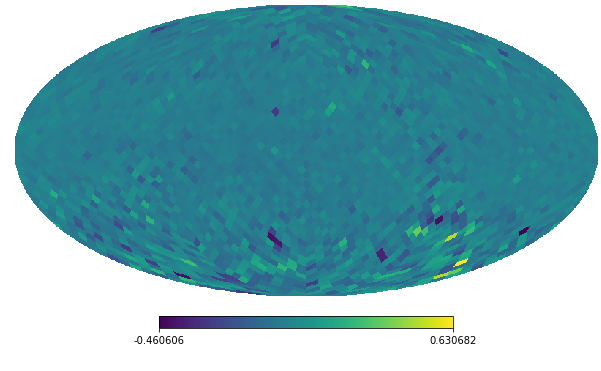

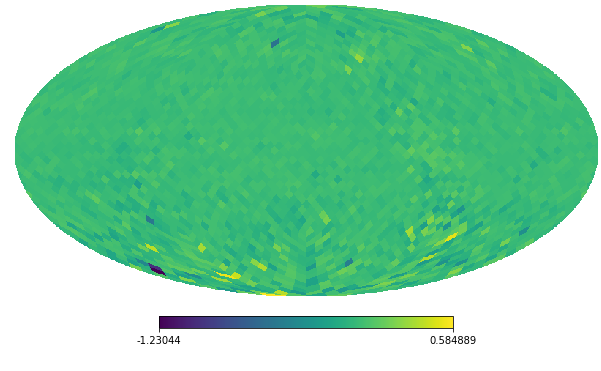

In [22]:
hp.mollview(hpx_map_RA)
hp.mollview(hpx_map_DEC)